In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load all the files

In [2]:
visitors0 = pd.read_csv('international-visitors-london-raw.csv')

In [3]:
gdp = pd.read_csv('gdp.csv', skiprows=3)

In [4]:
xls = pd.ExcelFile('PI_All_data_2007-2017.xlsx')

In [5]:
for i in xls.sheet_names[1:]:
    globals()['pi_%s' %i] = pd.read_excel('PI_All_data_2007-2017.xlsx', sheetname=i)

# Check the difference between PI data and visiters data. 

In [6]:
set(visitors0.market.unique()) - set(pi_Pillars.country.unique())

{'Irish Republic',
 'Other Africa',
 'Other Asia',
 'Other Central & South America',
 'Other Eastern Europe',
 'Other Middle East',
 'Other Southern Africa',
 'Other Western Europe',
 'Taiwan',
 'USA'}

# Change the names of some countries that don't match the GDP Data and PI data

In [7]:
visitors0.loc[visitors0['market'] == 'USA', 'market']= 'United States'
visitors0.loc[visitors0['market'] == 'Irish Republic', 'market']= 'Ireland'

# Join the Pi_data set with visitors data so the visitors dataset have region column.

In [8]:
visitors = visitors0.merge(pi_Pillars[['country','region']].drop_duplicates(), left_on='market', right_on='country', how='left')

In [9]:
visitors = visitors.drop('country', axis =1)

# Check the rows with null values

In [10]:
visitors[pd.isnull(visitors).region].market.unique()

array(['Other Western Europe', 'Other Eastern Europe',
       'Other Central & South America', 'Taiwan', 'Other Asia',
       'Other Middle East', 'Other Southern Africa', 'Other Africa'], dtype=object)

# Based on the geographical location of the data, we are going to catigorize the missing countries into the regions

In [11]:
visitors.loc[visitors['market'] == 'Taiwan', 'region']= 'East Asia'
visitors.loc[visitors['market'] == 'Other Western Europe', 'region']= 'Western Europe'
visitors.loc[visitors['market'] == 'Other Eastern Europe', 'region']= 'Eastern Europe'
visitors.loc[visitors['market'] == 'Other Central & South America', 'region']= 'Latin America and the Caribbean'

# Check the regions and the countries in them

In [12]:
visitors[visitors['region']== 'Europe']['market'].unique()

array(['Belgium', 'Luxembourg', 'France', 'Germany', 'Italy',
       'Netherlands', 'Denmark', 'Greece', 'Spain', 'Portugal', 'Austria',
       'Sweden', 'Finland', 'Ireland', 'Switzerland', 'Norway', 'Iceland'], dtype=object)

In [13]:
visitors[visitors['region']== 'Western Europe']['market'].unique()

array(['Other Western Europe'], dtype=object)

In [14]:
visitors[visitors['region']== 'Eastern Europe']['market'].unique()

array(['Czech Republic', 'Poland', 'Hungary', 'Russia',
       'Other Eastern Europe', 'Bulgaria', 'Romania', 'Serbia'], dtype=object)

In [15]:
visitors[pd.isnull(visitors).region].market.unique()

array(['Other Asia', 'Other Middle East', 'Other Southern Africa',
       'Other Africa'], dtype=object)

# We are going to impute the missing values in Asia 

In [16]:
#east asia is not in here because it is already captured by the data 
asian = ['South Asia', 'Western Asia', 'Southeast Asia', 'Central Asia']

In [17]:
for index, row in visitors.iterrows():
    if visitors.loc[index,'market'] == 'Other Asia':
        visitors.loc[index, 'region'] = np.random.choice(asian)

In [18]:
pi_Pillars.region.unique()

array(['South Asia', 'Eastern Europe', 'MENA', 'Sub-Saharan Africa',
       'Western Asia', 'Latin America and the Caribbean', 'Pacific Asia',
       'Europe', 'Southeast Asia', 'North America', 'East Asia',
       'Central Asia'], dtype=object)

# Based on the data and missing value, we are going to assume when the market equals to other middle east, the region is MENA, Middle East and North Africa region. 

In [19]:
for index, row in visitors.iterrows():
    if visitors.loc[index,'market'] == 'Other Middle East':
        visitors.loc[index, 'region'] = 'MENA'

In [20]:
visitors[pd.isnull(visitors).region]['market'].unique()

array(['Other Southern Africa', 'Other Africa'], dtype=object)

# After we imputed the missing values from market, we can see only other southern Africa and Other Afria left. We are going to impute them as Sub-Saharan Africa. 

In [21]:
visitors = visitors.fillna('Sub-Saharan Africa')

In [22]:
visitors[(visitors['purpose']=='Study') & (visitors['dur_stay'] =='15+  nights')].shape

(1337, 12)

In [23]:
visitors[(visitors['purpose']=='Study') & (visitors['dur_stay'] !='15+  nights')].shape

(1049, 12)

# As we can see from above, for students it is highly likely that they will stay for more than 15 days. For the purpose of the model. we are going to do analyses on people who are not here for study. 

In [24]:
visitors=visitors[visitors['purpose'] != 'Study']

# we are joining the GDP data with the visitors information

In [25]:
gdp =gdp.drop(['Country Code','Indicator Name','Indicator Code','1960','1961','1962','1963','1964','1965','1966','1967','1968','1969','1970','1971','1972','1973','1974','1975','1976','1977', '1978','1979','1980','1981','1982',
 '1983','1984','1985','1986','1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001'], axis =1)

In [26]:
gdp = pd.melt(gdp, id_vars=['Country Name'], value_vars=[str(i) for i in range(2002,2018)])

In [27]:
gdp.columns = ['country', 'year1','gdp']

# Change the GDP's country information into the proper information that can be matched with the visitors dataframe 

In [28]:
gdp.loc[gdp['country'] == 'Russian Federation', 'country']= 'Russia'
gdp.loc[gdp['country'] == 'Hong Kong SAR, China', 'country']= 'Hong Kong'
gdp.loc[gdp['country'] == 'Egypt, Arab Rep.', 'country']= 'Egypt'
gdp.loc[gdp['country'] == 'Korea, Rep.', 'country']= 'South Korea'


# converte the year variable to intiger so it can join the visitors table.

In [29]:
gdp['year1']=gdp['year1'].astype(np.int64)
visitors1 = visitors.merge(gdp, left_on=['market', 'year'], right_on=['country', 'year1'], how='left')

In [30]:
visitors1 =visitors1.drop(['year1', 'country'], axis =1)

In [31]:
visitors1.head(2)

,year,quarter,market,dur_stay,mode,purpose,area,visits,spend,nights,sample,region,gdp
0,2002,Q1,Belgium,1-3 nights,Air,Holiday,LONDON,3.572186,0.969138,6.954456,5,Europe,2.588604e+11
1,2002,Q1,Belgium,1-3 nights,Air,Business,LONDON,9.284226,2.399577,12.604959,19,Europe,2.588604e+11


# Below we are going to use the market value and region value to encode the missing values from GDP column

In [32]:
visitors1[visitors1['gdp'].isnull()]['market'].unique()

array(['Other Western Europe', 'Other Eastern Europe',
       'Other Central & South America', 'Taiwan', 'Other Asia',
       'Other Middle East', 'Other Southern Africa', 'Other Africa'], dtype=object)

In [33]:
visitors1.region.unique()

array(['Europe', 'MENA', 'Eastern Europe', 'Western Europe',
       'North America', 'Latin America and the Caribbean', 'East Asia',
       'Southeast Asia', 'Western Asia', 'Central Asia', 'South Asia',
       'Pacific Asia', 'Sub-Saharan Africa'], dtype=object)

# I am going to make eastern eurpoe and western europe's GDP equal to Europe's GDP

In [34]:
europe_average_gdp = visitors1[(visitors1['region']=='Europe')& (visitors1['gdp'].notnull())].groupby('year')['gdp'].mean().reset_index()

In [35]:
europe_average_gdp['region']= 'Western Europe'

In [36]:
europe_average_gdp['year1']=europe_average_gdp['year']
europe_average_gdp['gdp1'] =europe_average_gdp['gdp']
europe_average_gdp= europe_average_gdp.drop(['year','gdp'], axis =1)

In [37]:
visitors2 = visitors1.merge(europe_average_gdp, left_on=['region', 'year'], right_on=['region', 'year1'], how='left')

In [38]:
visitors2['gdp']=visitors2['gdp'].fillna(visitors2['gdp1'])

In [39]:
visitors2=visitors2.drop(['year1','gdp1'],axis =1)

In [40]:
visitors2[visitors2.gdp.isnull()]['market'].unique()

array(['Other Eastern Europe', 'Other Central & South America', 'Taiwan',
       'Other Asia', 'Other Middle East', 'Other Southern Africa',
       'Other Africa'], dtype=object)

In [41]:
europe_average_gdp['region']= 'Eastern Europe'

In [42]:
visitors2 = visitors2.merge(europe_average_gdp, left_on=['region', 'year'], right_on=['region', 'year1'], how='left')

In [43]:
visitors2['gdp']=visitors2['gdp'].fillna(visitors2['gdp1'])

In [44]:
visitors2=visitors2.drop(['year1','gdp1'],axis =1)

In [45]:
visitors2[visitors2.gdp.isnull()]['market'].unique()

array(['Other Central & South America', 'Taiwan', 'Other Asia',
       'Other Middle East', 'Other Southern Africa', 'Other Africa'], dtype=object)

In [46]:
visitors2[visitors2['gdp'].isnull()]['region'].unique()

array(['Latin America and the Caribbean', 'East Asia', 'Western Asia',
       'Central Asia', 'South Asia', 'Southeast Asia', 'MENA',
       'Sub-Saharan Africa'], dtype=object)

In [47]:
visitors2[(visitors2['gdp'].isnull())]['market'].unique()

array(['Other Central & South America', 'Taiwan', 'Other Asia',
       'Other Middle East', 'Other Southern Africa', 'Other Africa'], dtype=object)

# Change Taiwan's GDP to the mean of east Asia's GDP

In [48]:
asian_gdp= visitors2[(visitors2['region']=='East Asia')].groupby('year')['gdp'].mean().reset_index()

In [49]:
asian_gdp['region']='Taiwan'
asian_gdp['year1']= asian_gdp['year']
asian_gdp['gdp1']= asian_gdp['gdp']

In [50]:
asian_gdp = asian_gdp.drop(['year','gdp'], axis =1)

In [51]:
visitors2 = visitors2.merge(asian_gdp, left_on=['market', 'year'], right_on=['region', 'year1'], how='left')

In [52]:
visitors2['gdp'] = visitors2['gdp'].fillna(visitors2['gdp1'])

In [53]:
visitors2=visitors2.drop(['region_y', 'year1','gdp1'],axis =1)

In [54]:
visitors2[visitors2['gdp'].isnull()]['market'].unique()

array(['Other Central & South America', 'Other Asia', 'Other Middle East',
       'Other Southern Africa', 'Other Africa'], dtype=object)

In [55]:
visitors2[visitors2['gdp'].isnull()]['region_x'].unique()

array(['Latin America and the Caribbean', 'Western Asia', 'Central Asia',
       'South Asia', 'Southeast Asia', 'MENA', 'Sub-Saharan Africa'], dtype=object)

In [56]:
visitors2[visitors2['region_x']=='South Asia']['market'].unique()

array(['Other Asia', 'India', 'Pakistan'], dtype=object)

In [57]:
visitors2['region_x'].unique()

array(['Europe', 'MENA', 'Eastern Europe', 'Western Europe',
       'North America', 'Latin America and the Caribbean', 'East Asia',
       'Southeast Asia', 'Western Asia', 'Central Asia', 'South Asia',
       'Pacific Asia', 'Sub-Saharan Africa'], dtype=object)

# There are still some Asian countries that don't have correct GDP, so we are going to make the the average of the asian GDP

In [58]:
asian_gdp['region']='Other Asia'

In [59]:
visitors2 = visitors2.merge(asian_gdp, left_on=['market', 'year'], right_on=['region', 'year1'], how='left')

In [60]:
visitors2['gdp'] = visitors2['gdp'].fillna(visitors2['gdp1'])

In [61]:
visitors2=visitors2.drop(['region', 'year1','gdp1'],axis =1)

In [62]:
visitors2[visitors2['gdp'].isnull()]['market'].unique()

array(['Other Central & South America', 'Other Middle East',
       'Other Southern Africa', 'Other Africa'], dtype=object)

In [63]:
visitors2[visitors2['gdp'].isnull()]['region_x'].unique()

array(['Latin America and the Caribbean', 'MENA', 'Sub-Saharan Africa'], dtype=object)

# We are also going to use the mean Eurpo's DGP to impute the missing values for europe GDPs.

In [64]:
europe_gdp= visitors2[(visitors2['region_x']=='Eastern Europe')| (visitors2['region_x']=='Europe')].groupby('year')['gdp'].mean().reset_index()

In [65]:
europe_gdp['region']='Other Western Europe'

In [66]:
europe_gdp['year1'] = europe_gdp['year']
europe_gdp['gdp1']= europe_gdp['gdp']
europe_gdp= europe_gdp.drop(['year','gdp'],axis =1)

In [67]:
visitors2 = visitors2.merge(europe_gdp, left_on=['market', 'year'], right_on=['region', 'year1'], how='left')

In [68]:
visitors2['gdp'] = visitors2['gdp'].fillna(visitors2['gdp1'])

In [69]:
visitors2=visitors2.drop(['region', 'year1','gdp1'],axis =1)

In [70]:
visitors2[visitors2['gdp'].isnull()]['market'].unique()

array(['Other Central & South America', 'Other Middle East',
       'Other Southern Africa', 'Other Africa'], dtype=object)

# I am going to impute the missing values for other middle east using mean of the MENA's GDP

In [71]:
africa_gdp = visitors2[visitors2['region_x']=='MENA'].groupby('year')['gdp'].mean().reset_index()

In [72]:
africa_gdp['region'] = 'Other Middle East'

In [73]:
africa_gdp.rename(index=str, columns={"year": "year1", "gdp": "gdp1"}, inplace = True)

In [74]:
visitors2 = visitors2.merge(africa_gdp, left_on=['market', 'year'], right_on=['region', 'year1'], how='left')

In [75]:
visitors2['gdp'] = visitors2['gdp'].fillna(visitors2['gdp1'])

In [76]:
visitors2=visitors2.drop(['region', 'year1','gdp1'],axis =1)

In [77]:
visitors2[visitors2['gdp'].isnull()]['market'].unique()

array(['Other Central & South America', 'Other Southern Africa',
       'Other Africa'], dtype=object)

In [78]:
visitors2[visitors2['gdp'].isnull()]['region_x'].unique()

array(['Latin America and the Caribbean', 'Sub-Saharan Africa'], dtype=object)

# Impute other africa's gdp

In [79]:
africa_gdp['region']= 'Other Africa'

In [80]:
visitors2 = visitors2.merge(africa_gdp, left_on=['market', 'year'], right_on=['region', 'year1'], how='left')
visitors2['gdp'] = visitors2['gdp'].fillna(visitors2['gdp1'])
visitors2=visitors2.drop(['region', 'year1','gdp1'],axis =1)

In [81]:
visitors2[visitors2['gdp'].isnull()]['market'].unique()

array(['Other Central & South America', 'Other Southern Africa'], dtype=object)

In [82]:
africa_gdp['region']= 'Other Southern Africa'
visitors2 = visitors2.merge(africa_gdp, left_on=['market', 'year'], right_on=['region', 'year1'], how='left')
visitors2['gdp'] = visitors2['gdp'].fillna(visitors2['gdp1'])
visitors2=visitors2.drop(['region', 'year1','gdp1'],axis =1)

In [83]:
visitors2[visitors2['gdp'].isnull()]['market'].unique()

array(['Other Central & South America'], dtype=object)

In [84]:
visitors2[visitors2['gdp'].isnull()]['region_x'].unique()

array(['Latin America and the Caribbean'], dtype=object)

# For the countries in Latin America and Caribbeans, we are going to calulate the mean GDP and use them to imput the catigory Latin America and the Caribbeans. 

In [85]:
central_south_america = ['Belize','Costa Rica', 'El Salvador','Guatemala', 'Honduras','Nicaragua','Panama', 'Bolivia','Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname','Uruguay', 'Venezuela']

In [86]:
central_america_gdp = gdp[gdp['country'].isin(central_south_america)].groupby('year1')['gdp'].mean().reset_index()

In [87]:
central_america_gdp['region'] = 'Latin America and the Caribbean'

In [88]:
central_america_gdp.rename(index=str, columns={"year": "year1", "gdp": "gdp1"}, inplace = True)

In [89]:
visitors2 = visitors2.merge(central_america_gdp, left_on=['region_x', 'year'], right_on=['region', 'year1'], how='left')


In [90]:
visitors2['gdp'] = visitors2['gdp'].fillna(visitors2['gdp1'])
visitors2=visitors2.drop(['region', 'year1','gdp1'],axis =1)

# For the PI table, we only have data after 2006, so we are going to drop some data from the origional dataset and joing the visitors table with the PI table

In [91]:
visitors3 = visitors2[visitors2['year'] >2006]

In [92]:
visitors3.rename(index=str, columns={ "region_x": "region"}, inplace = True)

/Users/elvy/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


# Because the PI dataset has similar structure as the GDP dataset, we are going to write a function to do everything we did before to join everything in PI with the visitors dataset.

In [93]:
def mergedata(visitors_org, merger_data, column):
    merger_data = merger_data[['country','year', column]]
    visitors4 = visitors_org.merge(merger_data, left_on=['market','year'], right_on=['country','year'], how='left')
    visitors4 = visitors4.drop('country',axis =1)
    europe_average = visitors4[(visitors4['region']=='Europe')& (visitors4[column].notnull())].groupby('year')[column].mean().reset_index()
    europe_average['region']= 'Western Europe'
    europe_average['year1']=europe_average['year']
    europe_average['gdp1'] =europe_average[column]
    europe_average= europe_average.drop(['year',column], axis =1)
    visitors4 = visitors4.merge(europe_average, left_on=['region', 'year'], right_on=['region', 'year1'], how='left')
    visitors4[column]=visitors4[column].fillna(visitors4['gdp1'])
    visitors4=visitors4.drop(['year1','gdp1'],axis =1)
    europe_average['region']= 'Eastern Europe'
    visitors4 = visitors4.merge(europe_average, left_on=['region', 'year'], right_on=['region', 'year1'], how='left')
    visitors4[column]=visitors4[column].fillna(visitors4['gdp1'])
    visitors4=visitors4.drop(['year1','gdp1'],axis =1)
    asian= visitors4[(visitors4['region']=='East Asia')].groupby('year')[column].mean().reset_index()
    asian['region']='Taiwan'
    asian['year1']= asian['year']
    asian['gdp1']= asian[column]
    asian = asian.drop(['year',column], axis =1)
    visitors4 = visitors4.merge(asian, left_on=['market', 'year'], right_on=['region', 'year1'], how='left')
    visitors4[column] = visitors4[column].fillna(visitors4['gdp1'])
    visitors4=visitors4.drop(['region_y', 'year1','gdp1'],axis =1)
    asian['region']='Other Asia'
    visitors4 = visitors4.merge(asian, left_on=['market', 'year'], right_on=['region', 'year1'], how='left')
    visitors4[column] = visitors4[column].fillna(visitors4['gdp1'])
    visitors4=visitors4.drop(['region', 'year1','gdp1'],axis =1)
    europe_value= visitors4[(visitors4['region_x']=='Eastern Europe')| (visitors4['region_x']=='Europe')].groupby('year')[column].mean().reset_index()
    europe_value['region']='Other Western Europe'
    europe_value['year1'] = europe_value['year']
    europe_value['gdp1']= europe_value[column]
    europe_value= europe_value.drop(['year',column],axis =1)
    visitors4 = visitors4.merge(europe_value, left_on=['market', 'year'], right_on=['region', 'year1'], how='left')
    visitors4[column] = visitors4[column].fillna(visitors4['gdp1'])
    visitors4=visitors4.drop(['region', 'year1','gdp1'],axis =1)
    africa_value = visitors4[visitors4['region_x']=='MENA'].groupby('year')[column].mean().reset_index()
    africa_value['region'] = 'Other Middle East'
    africa_value.rename(index=str, columns={"year": "year1", column: "gdp1"}, inplace = True)
    visitors4 = visitors4.merge(africa_value, left_on=['market', 'year'], right_on=['region', 'year1'], how='left')
    visitors4[column] = visitors4[column].fillna(visitors4['gdp1'])
    visitors4=visitors4.drop(['region', 'year1','gdp1'],axis =1)
    africa_value['region']= 'Other Africa'
    visitors4 = visitors4.merge(africa_value, left_on=['market', 'year'], right_on=['region', 'year1'], how='left')
    visitors4[column] = visitors4[column].fillna(visitors4['gdp1'])
    visitors4=visitors4.drop(['region', 'year1','gdp1'],axis =1)
    africa_value['region']= 'Other Southern Africa'
    visitors4 = visitors4.merge(africa_value, left_on=['market', 'year'], right_on=['region', 'year1'], how='left')
    visitors4[column] = visitors4[column].fillna(visitors4['gdp1'])
    visitors4=visitors4.drop(['region', 'year1','gdp1'],axis =1)
    central_south_america = ['Belize','Costa Rica', 'El Salvador','Guatemala', 'Honduras','Nicaragua','Panama', 'Bolivia','Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname','Uruguay', 'Venezuela']
    central_america_value = merger_data[merger_data['country'].isin(central_south_america)].groupby('year')[column].mean().reset_index()
    central_america_value['region'] = 'Latin America and the Caribbean'
    central_america_value.rename(index=str, columns={"year": "year1", column: "gdp1"}, inplace = True)
    visitors4 = visitors4.merge(central_america_value, left_on=['region_x', 'year'], right_on=['region', 'year1'], how='left')
    visitors4[column] = visitors4[column].fillna(visitors4['gdp1'])
    visitors4=visitors4.drop(['region', 'year1','gdp1'],axis =1)

    return visitors4

In [94]:
new_frame = visitors3
for i in  ['PI','econ','busi','gove','educ','heal','safe','pers','soci','envi']:
    new_frame = mergedata(new_frame, pi_Pillars, i)
    new_frame.rename(index=str, columns={"region_x": "region"}, inplace = True)

# join the econ_var table in the dataframe 

In [95]:
frame = new_frame
for i in list(pi_econ_var.iloc[:,list(range(12,34))]):
    frame = mergedata(frame, pi_econ_var.iloc[:,[0,3]+list(range(12,34))], i)
    frame.rename(index=str, columns={"region_x": "region"}, inplace = True)

# Joion the busi_var table

In [96]:
for i in list(pi_busi_var.iloc[:,list(range(12,30))]):
    frame = mergedata(frame, pi_busi_var.iloc[:,[0,3]+list(range(12,30))], i)
    frame.rename(index=str, columns={"region_x": "region"}, inplace = True)

# Join the gove_var table

In [97]:
for i in list(pi_gove_var.iloc[:, [10,11,12,13]+ list(range(16,34))]):
    frame = mergedata(frame, pi_gove_var.iloc[:, [0,3,10,11,12,13]+ list(range(16,34))], i)
    frame.rename(index=str, columns={"region_x": "region"}, inplace = True)



# join pi_educ_var

In [98]:
for i in list(pi_educ_var.iloc[:,[8,9,12,13,14,15]+list(range(18,32))]):
    frame = mergedata(frame, pi_educ_var.iloc[:,[0,3,8,9,12,13,14,15]+list(range(18,32))], i)
    frame.rename(index=str, columns={"region_x": "region"}, inplace = True)


# Join heal_var

In [99]:
for i in list(pi_heal_var.iloc[:,[10,11,14,15,16,17,20,21,22,23,24,25,26,27,30,31]]):
    frame = mergedata(frame, pi_heal_var.iloc[:,[0,3,10,11,14,15,16,17,20,21,22,23,24,25,26,27,30,31]], i)
    frame.rename(index=str, columns={"region_x": "region"}, inplace = True)



In [100]:
for i in list(pi_safe_var.iloc[:,[8,9,24,25,28,29]+list(range(12,20))]):
    frame = mergedata(frame, pi_safe_var.iloc[:,[0,3,8,9,24,25,28,29]+list(range(12,20))], i)
    frame.rename(index=str, columns={"region_x": "region"}, inplace = True)



In [101]:
for i in list(pi_pers_var.iloc[:, [8,9,10,11,12,13,18,19,22,23,24,25,28,29,30,31]]):
    frame = mergedata(frame, pi_pers_var.iloc[:, [0,3,8,9,10,11,12,13,18,19,22,23,24,25,28,29,30,31]], i)
    frame.rename(index=str, columns={"region_x": "region"}, inplace = True)


In [102]:
for i in list(pi_soci_var.iloc[:,[-2,-1]]):
    frame = mergedata(frame, pi_soci_var.iloc[:,[0,3,-2,-1]], i)
    frame.rename(index=str, columns={"region_x": "region"}, inplace = True)


In [103]:
for i in list(pi_envi_var.iloc[:,[22,23,24,25]+list(range(8,20))]):
    frame = mergedata(frame, pi_envi_var.iloc[:,[0,3,22,23,24,25]+list(range(8,20))], i)
    frame.rename(index=str, columns={"region_x": "region"}, inplace = True)


# after we join all the data, I am going to check if everything ran smoothly.

In [104]:
frame

,year,quarter,market,dur_stay,mode,purpose,area,visits,spend,nights,...,fishstock,fishstock_dtf,fwateruse,fwateruse_dtf,improved_drinkwater,improved_drinkwater_dtf,marineprotect,marineprotect_dtf,pestreg,pestreg_dtf
0,2007,Q1,Belgium,1-3 nights,Air,Holiday,LONDON,0.753385,0.087581,0.753385,...,50.878780,0.491212,51.800000,0.482000,100.000000,1.000000,0.043200,0.000432,23.000000,0.920000
1,2007,Q1,Belgium,1-3 nights,Air,Business,LONDON,4.625445,1.555299,6.869618,...,50.878780,0.491212,51.800000,0.482000,100.000000,1.000000,0.043200,0.000432,23.000000,0.920000
2,2007,Q1,Belgium,1-3 nights,Air,VFR,LONDON,1.225540,0.048458,1.793118,...,50.878780,0.491212,51.800000,0.482000,100.000000,1.000000,0.043200,0.000432,23.000000,0.920000
3,2007,Q1,Belgium,1-3 nights,Air,Miscellaneous,LONDON,1.023070,0.208063,1.776455,...,50.878780,0.491212,51.800000,0.482000,100.000000,1.000000,0.043200,0.000432,23.000000,0.920000
4,2007,Q1,Belgium,1-3 nights,Sea,Holiday,LONDON,6.439640,0.438086,8.448400,...,50.878780,0.491212,51.800000,0.482000,100.000000,1.000000,0.043200,0.000432,23.000000,0.920000
5,2007,Q1,Belgium,1-3 nights,Tunnel,Holiday,LONDON,13.735650,3.255361,26.701581,...,50.878780,0.491212,51.800000,0.482000,100.000000,1.000000,0.043200,0.000432,23.000000,0.920000
6,2007,Q1,Belgium,1-3 nights,Tunnel,Business,LONDON,11.917938,3.212330,17.576485,...,50.878780,0.491212,51.800000,0.482000,100.000000,1.000000,0.043200,0.000432,23.000000,0.920000
7,2007,Q1,Belgium,1-3 nights,Tunnel,VFR,LONDON,7.796814,1.019411,13.213334,...,50.878780,0.491212,51.800000,0.482000,100.000000,1.000000,0.043200,0.000432,23.000000,0.920000
8,2007,Q1,Belgium,1-3 nights,Tunnel,Miscellaneous,LONDON,1.232798,0.965997,2.415030,...,50.878780,0.491212,51.800000,0.482000,100.000000,1.000000,0.043200,0.000432,23.000000,0.920000
9,2007,Q1,Belgium,4-7 nights,Air,Holiday,LONDON,0.276795,0.142273,1.107180,...,50.878780,0.491212,51.800000,0.482000,100.000000,1.000000,0.043200,0.000432,23.000000,0.920000


In [105]:
frame.shape

(35915, 169)

# because the column names contain dtf are standarderedlized values of the ones without the dtf tag, we are going to delete the columns with dtf tag.

In [106]:
cols = [c for c in frame.columns if c.lower()[-4:] != '_dtf']

In [107]:
frame1 = frame[cols]

# We are going to mark our target variable with 1 which stands for people who stay over 15 days, and the other variables as 0 

In [108]:
frame2 = frame1
frame2['y'] = '0'
frame2.loc[frame2['dur_stay'] == '15+  nights', 'y']= '1'

/Users/elvy/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/elvy/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Below we are going to use 2017 as our test set, 2016 and 2015 as validation. other data as train. 

In [109]:
train = frame2[(frame2['year']!=2016)& (frame2['year']!=2015) & (frame2['year']!=2017)]

In [110]:
validation = frame2[(frame2['year']==2016)|(frame2['year']==2015)]

In [111]:
test = frame2[(frame2['year']==2017)]

# Model

In [124]:
import h2o
import math
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(nthreads=-1, strict_version_check=True)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_161"; Java(TM) SE Runtime Environment (build 1.8.0_161-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)
  Starting server from /Users/elvy/anaconda3/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gn/gtpjhb555nbfkztvq_m7_84w0000gn/T/tmpsac455x_
  JVM stdout: /var/folders/gn/gtpjhb555nbfkztvq_m7_84w0000gn/T/tmpsac455x_/h2o_elvy_started_from_python.out
  JVM stderr: /var/folders/gn/gtpjhb555nbfkztvq_m7_84w0000gn/T/tmpsac455x_/h2o_elvy_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.16.0.4
H2O cluster version age:,10 months and 6 days !!!
H2O cluster name:,H2O_from_python_elvy_89jrir
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [125]:
trainh = h2o.H2OFrame(train)
validh = h2o.H2OFrame(validation)
testh  = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [126]:
y = 'y'
X = [name for name in trainh.columns if name not in [y,'market','nights','sample','dur_stay']]

In [127]:
trainh[y] = trainh[y].asfactor()
validh[y] = validh[y].asfactor()
testh[y]  = testh[y].asfactor()

# The first model is without make the target variable balanced.

In [128]:
# define random grid search parameters
hyper_parameters = {'ntrees':list(range(1, 100, 10)),
                    'max_depth':list(range(1, 30, 2)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':20,
                   'max_runtime_secs':600}

# initialize grid search
gsearch_nobalance = H2OGridSearch(H2OGradientBoostingEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch_nobalance.train(
    x=X,
    y=y,
    training_frame=trainh,
    validation_frame=validh)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [130]:
gbm_model = gsearch_nobalance.get_grid()[0]
print(gbm_model.auc(train=True))
print(gbm_model.auc(valid=True))
print(gbm_model.model_performance(test_data=testh).auc())

0.956591435622665
0.8233828366975144
0.8180597328570115


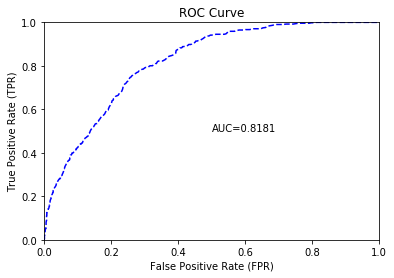

In [131]:
gbm_model.model_performance(test_data=testh).plot()

In [132]:
gbm_model.model_performance(test_data=testh)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.10939541087917888
RMSE: 0.3307497707923301
LogLoss: 0.347014209667333
Mean Per-Class Error: 0.25266982463360144
AUC: 0.8180597328570115
Gini: 0.636119465714023
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1640943940295915: 


,0,1,Error,Rate
0,1991.0,691.0,0.2576,(691.0/2682.0)
1,129.0,382.0,0.2524,(129.0/511.0)
Total,2120.0,1073.0,0.2568,(820.0/3193.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1640944,0.4823232,255.0
max f2,0.0961476,0.6295366,303.0
max f0point5,0.4865762,0.4652937,97.0
max accuracy,0.5443849,0.8537426,79.0
max precision,0.8708066,0.75,9.0
max recall,0.0151649,1.0,384.0
max specificity,0.9651573,0.9996271,0.0
max absolute_mcc,0.1573410,0.3813232,259.0
max min_per_class_accuracy,0.1657291,0.7436399,254.0
max mean_per_class_accuracy,0.1573410,0.7473302,259.0


Gains/Lift Table: Avg response rate: 16.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100219,0.7972542,4.4911326,4.4911326,0.71875,0.71875,0.0450098,0.0450098,349.1132583,349.1132583
,2,0.0200438,0.6970832,4.2958659,4.3934993,0.6875,0.703125,0.0430528,0.0880626,329.5865949,339.3499266
,3,0.0300658,0.6241573,4.4911326,4.4260437,0.71875,0.7083333,0.0450098,0.1330724,349.1132583,342.6043705
,4,0.0400877,0.5802672,3.1242661,4.1005993,0.5,0.65625,0.0313112,0.1643836,212.4266145,310.0599315
,5,0.0501096,0.5311059,3.1242661,3.9053327,0.5,0.625,0.0313112,0.1956947,212.4266145,290.5332681
,6,0.1002192,0.3856018,2.4603596,3.1828461,0.39375,0.509375,0.1232877,0.3189824,146.0359589,218.2846135
,7,0.1500157,0.3076645,2.0435452,2.8046648,0.3270440,0.4488518,0.1017613,0.4207436,104.3545151,180.4664806
,8,0.2001253,0.2507663,1.7573997,2.5424388,0.28125,0.4068858,0.0880626,0.5088063,75.7399706,154.2438803
,9,0.3000313,0.1832259,1.7041452,2.2632993,0.2727273,0.3622129,0.1702544,0.6790607,70.4145170,126.3299274
,10,0.3999374,0.1310476,1.2340362,2.0061850,0.1974922,0.3210650,0.1232877,0.8023483,23.4036158,100.6184995


# GBM Model 2 this model is after we making the target value balanced

In [133]:
# define random grid search parameters
hyper_parameters = {'ntrees':list(range(1, 100, 10)),
                    'max_depth':list(range(1, 40, 2)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)],
                   'balance_classes' : True}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':20,
                   'max_runtime_secs':600}

# initialize grid search
gsearch = H2OGridSearch(H2OGradientBoostingEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(
    x=X,
    y=y,
    training_frame=trainh,
    validation_frame=validh)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [134]:
gs_1 = gsearch.get_grid()[0]

In [135]:
print(gs_1.auc(train=True))
print(gs_1.auc(valid=True))
print(gs_1.model_performance(test_data=testh).auc())

0.8730884955265883
0.8078182166529728
0.7961911036977691


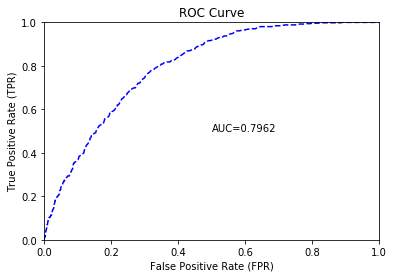

In [136]:
gs_1.model_performance(test_data=testh).plot()

In [137]:
gs_1.model_performance(test_data=testh)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.11534410267019787
RMSE: 0.33962347190704867
LogLoss: 0.363539466092946
Mean Per-Class Error: 0.270103582482915
AUC: 0.7961911036977691
Gini: 0.5923822073955383
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1579476579306784: 


,0,1,Error,Rate
0,1994.0,688.0,0.2565,(688.0/2682.0)
1,158.0,353.0,0.3092,(158.0/511.0)
Total,2152.0,1041.0,0.265,(846.0/3193.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1579477,0.4548969,234.0
max f2,0.0774718,0.6115203,309.0
max f0point5,0.2825640,0.4130534,145.0
max accuracy,0.5052950,0.8449734,47.0
max precision,0.7362730,0.6666667,2.0
max recall,0.0122491,1.0,387.0
max specificity,0.7661873,0.9996271,0.0
max absolute_mcc,0.1313029,0.3449061,259.0
max min_per_class_accuracy,0.1488385,0.7192394,243.0
max mean_per_class_accuracy,0.1313029,0.7298964,259.0


Gains/Lift Table: Avg response rate: 16.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100219,0.5840447,3.7100660,3.7100660,0.59375,0.59375,0.0371820,0.0371820,271.0066047,271.0066047
,2,0.0200438,0.5316734,3.5147994,3.6124327,0.5625,0.578125,0.0352250,0.0724070,251.4799413,261.2432730
,3,0.0300658,0.4825315,3.1242661,3.4497105,0.5,0.5520833,0.0313112,0.1037182,212.4266145,244.9710535
,4,0.0400877,0.4452555,2.1479330,3.1242661,0.34375,0.5,0.0215264,0.1252446,114.7932975,212.4266145
,5,0.0501096,0.4188160,3.3195328,3.1633195,0.53125,0.50625,0.0332681,0.1585127,231.9532779,216.3319472
,6,0.1002192,0.3198554,2.4994129,2.8313662,0.4,0.453125,0.1252446,0.2837573,149.9412916,183.1366194
,7,0.1500157,0.2630717,2.0042462,2.5568107,0.3207547,0.4091858,0.0998043,0.3835616,100.4246206,155.6810707
,8,0.2001253,0.2271430,1.9917197,2.4153169,0.31875,0.3865415,0.0998043,0.4833659,99.1719667,141.5316863
,9,0.3000313,0.1715366,1.6649694,2.1654621,0.2664577,0.3465553,0.1663405,0.6497065,66.4969419,116.5462130
,10,0.3999374,0.1296693,1.3319755,1.9572537,0.2131661,0.3132341,0.1330724,0.7827789,33.1975535,95.7253654


# Random Forest Model

In [138]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
# define random grid search parameters
hyper_parameters = {'ntrees':list(range(1, 500, 10)),
                    'max_depth':list(range(1, 10, 2)),
                   'stopping_metric' : 'auc'}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':20,
                   'max_runtime_secs':600}

# initialize grid search
rf_search = H2OGridSearch(H2ORandomForestEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
rf_search.train(
    x=X,
    y=y,
    training_frame=trainh,
    validation_frame=validh)



drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [139]:
rf_pram = rf_search.get_grid()[0]

In [140]:
print(rf_pram.auc(train=True))
print(rf_pram.auc(valid=True))
print(rf_pram.model_performance(test_data=testh).auc())

0.7224888698909464
0.7646724809505611
0.766226900799853


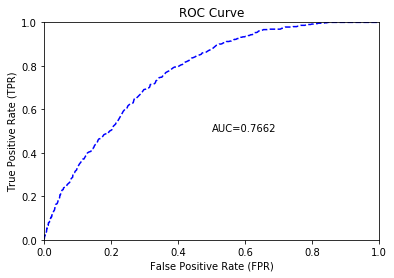

In [141]:
rf_pram.model_performance(test_data=testh).plot()

In [142]:
rf_pram.model_performance(test_data=testh)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.12220333263474256
RMSE: 0.3495759325736578
LogLoss: 0.3945509388597151
Mean Per-Class Error: 0.29722722039077654
AUC: 0.766226900799853
Gini: 0.532453801599706
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1934780166990875: 


,0,1,Error,Rate
0,1883.0,799.0,0.2979,(799.0/2682.0)
1,158.0,353.0,0.3092,(158.0/511.0)
Total,2041.0,1152.0,0.2997,(957.0/3193.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1934780,0.4245340,174.0
max f2,0.1543731,0.5888377,235.0
max f0point5,0.2306204,0.3790028,116.0
max accuracy,0.3694763,0.8415283,17.0
max precision,0.4845454,1.0,0.0
max recall,0.0874154,1.0,332.0
max specificity,0.4845454,1.0,0.0
max absolute_mcc,0.1812609,0.3004727,194.0
max min_per_class_accuracy,0.1920157,0.6942580,176.0
max mean_per_class_accuracy,0.1812609,0.7027728,194.0


Gains/Lift Table: Avg response rate: 16.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100219,0.3502662,3.1242661,3.1242661,0.5,0.5,0.0313112,0.0313112,212.4266145,212.4266145
,2,0.0200438,0.3146018,3.5147994,3.3195328,0.5625,0.53125,0.0352250,0.0665362,251.4799413,231.9532779
,3,0.0300658,0.2938351,2.5384662,3.0591773,0.40625,0.4895833,0.0254403,0.0919765,153.8466243,205.9177267
,4,0.0400877,0.2800694,2.7337329,2.9778162,0.4375,0.4765625,0.0273973,0.1193738,173.3732877,197.7816169
,5,0.0501096,0.2720657,2.5384662,2.8899462,0.40625,0.4625,0.0254403,0.1448141,153.8466243,188.9946184
,6,0.1002192,0.2428121,2.2260396,2.5579929,0.35625,0.409375,0.1115460,0.2563601,122.6039628,155.7992906
,7,0.1500157,0.2307315,2.0042462,2.3741814,0.3207547,0.3799582,0.0998043,0.3561644,100.4246206,137.4181371
,8,0.2001253,0.2215561,1.6402397,2.1904088,0.2625,0.3505477,0.0821918,0.4383562,64.0239726,119.0408815
,9,0.3000313,0.2016547,1.6257937,2.0024002,0.2601881,0.3204593,0.1624266,0.6007828,62.5793668,100.2400222
,10,0.3999374,0.1858582,1.3319755,1.8349253,0.2131661,0.2936570,0.1330724,0.7338552,33.1975535,83.4925300


# We have also attempted logistic regression , but the result was not as good. So our final model has an AUC of 0.817. False negative rate is 0.285. 

# GBM 1 Analysis

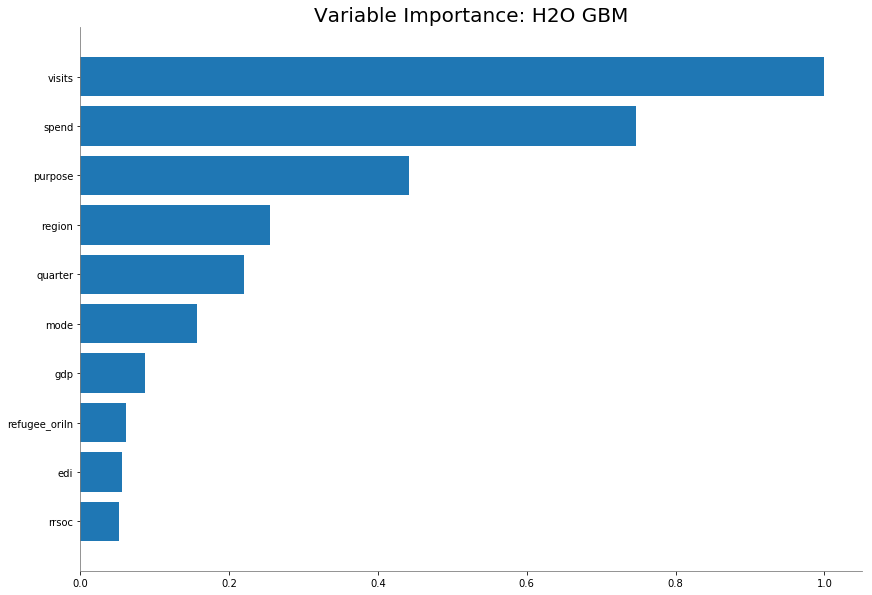

In [143]:
gbm_model.varimp_plot()

In [144]:
test1 = testh

In [145]:
test1['p_prediction']=gbm_model.predict(testh).drop(['predict', 'p0'])

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [154]:
test1.as_data_frame().to_csv('prediction.csv')

In [146]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=3,       # shallow trees are easier to understand
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y='p_prediction', training_frame=test1)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /Users/elvy/Documents/GWU/Practicum/dt_surrogate_mojo.zip


In [147]:
from h2o.backend import H2OLocalServer 
import os
import re
import subprocess

# in-notebook display
from IPython.display import Image
from IPython.display import display

title = 'London Tourist Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /Users/elvy/anaconda3/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /Users/elvy/anaconda3/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/elvy/Documents/GWU/Practicum/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title London Tourist Decision Tree Surrogate


In [148]:

# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


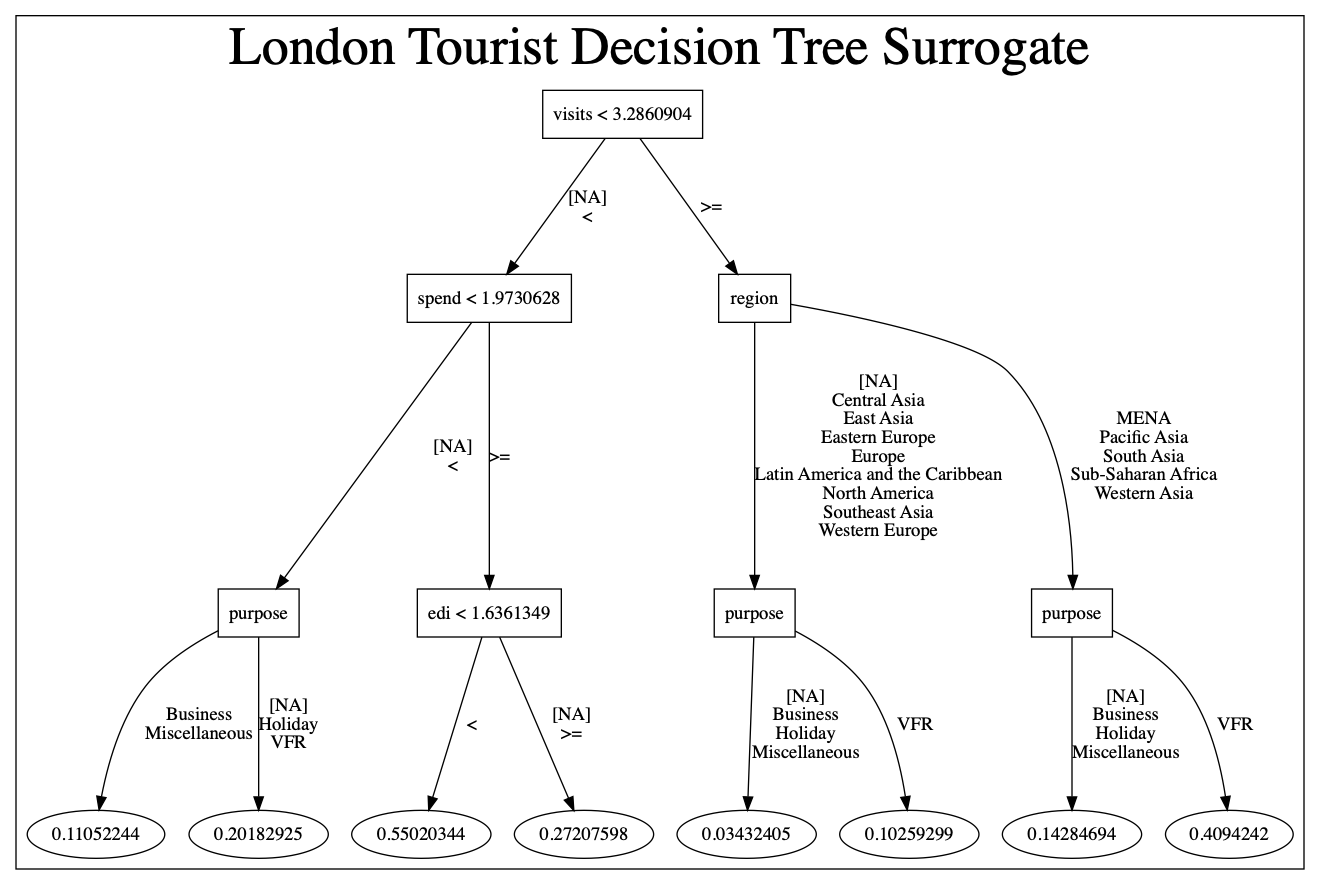

In [149]:
display(Image((png_file_name)))

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


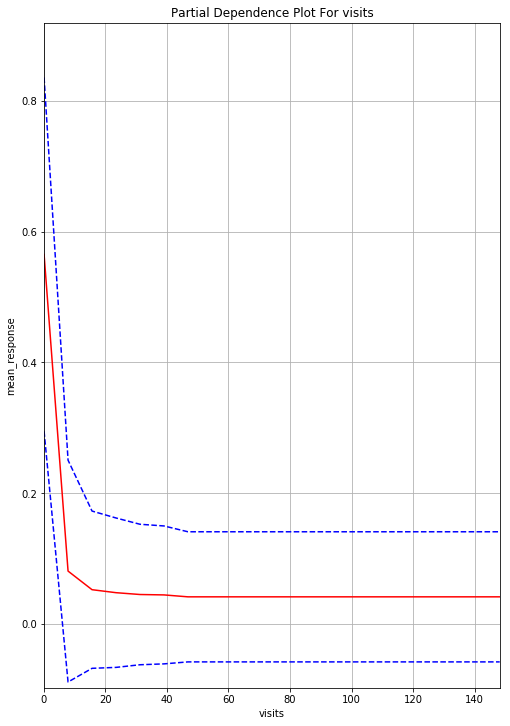

In [150]:
%matplotlib inline
par_dep_visits = gbm_model.partial_plot(data=trainh, cols=['visits'], server=True, plot=True)